Agglomerative Clustering
===

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import cut_tree
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from IPython.display import display, clear_output


%matplotlib inline

# Define some useful functions before getting started

Turns out that the agglomerative clustering algorithm doesn't return cluster centers, so we want to have an algorithm that finds the cluster centers for us.  And other nice things like plotting and metrics.

In [37]:
#Plotting function
def plot_clusters(labels, clusters, X,idx1=0,idx2=1,xlabel="X",ylabel="Y",linkLabel="none"):
    unique_labels = set(labels)
    colors = cm.Spectral(np.linspace(0, 1, len(unique_labels)))
    plt.figure(figsize=(10,8))
    for k, col in zip(unique_labels, colors):
        class_member_mask = (labels == k)
        xy = X[class_member_mask]
        plt.plot(xy[:, idx1], xy[:, idx2], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=5, alpha=0.5)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.plot(clusters[k,idx1],clusters[k,idx2],'o',markerfacecolor=col,
             markeredgecolor='k', markersize=20,alpha=0.8)
    plt.title("Linkage = {}".format(linkLabel))  
        
#calculate cluster centers, as Agglomerative clustering doesn't do this by default
def getClusterCenters(X,labels):
    ncl = np.max(labels)+1
    dims = X[0,:].size
    
    centers = np.zeros((ncl,dims))
    
    for idx in range(ncl):
        for dim in range(dims):
            centers[idx,dim] = np.mean(X[labels==idx,dim])
    
    return centers

# Convenient way of getting metrics
def rank_clusters(X,labels,truth_labels=[],verbose=True):
    retval = np.zeros(2)
    retval[0] = metrics.silhouette_score(X,labels) #larger is better!
    retval[1] = metrics.davies_bouldin_score(X,labels) #lower is better!
    if verbose:
        print("Silhouette Score: ",retval[0])
        print("Davies-Bouldin Score: ",retval[1])
    
    return retval

# another metric that's based on cluster distances, similar to Davies-Bouldin
def get_pdist(model,X,verbose=True):
    c, coph_dists = cophenet(model, pdist(X))
    print("Cophenetic Correlation Coefficient: ",c)
    return c

Generate Data
---

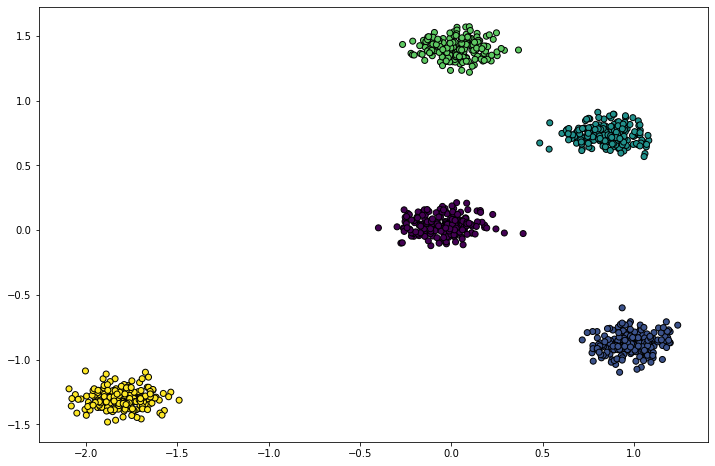

In [38]:
#Set cluster standard deviation
std=0.5

nTrue_Clusters = 5

# Generate sample data
X, labels_true = make_blobs(n_samples=1000, centers=nTrue_Clusters, cluster_std=std,random_state=18)
X = StandardScaler().fit_transform(X)

fig = plt.figure(figsize=(12,8))
plt.scatter(X[:,0],X[:,1],edgecolor='0',c=labels_true)
plt.show()

# Run Agglomerative Clustering
---
Agglomerative clustering requires the user to specify the "linkage", which is the means by which objects are associated with clusters.  We will explore four different options to see which seems to work best for our problem.


Linkage =  average


<Figure size 432x288 with 0 Axes>

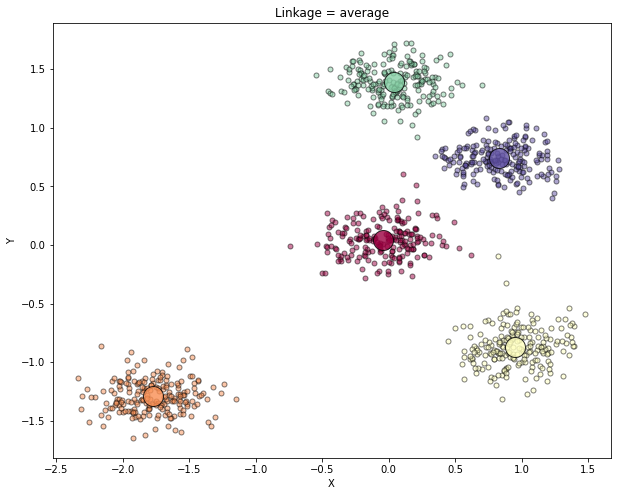

Silhouette Score:  0.7280863504858219
Davies-Bouldin Score:  0.3795481716373693
Cophenetic Correlation Coefficient:  0.9148192548721745

Linkage =  single


<Figure size 432x288 with 0 Axes>

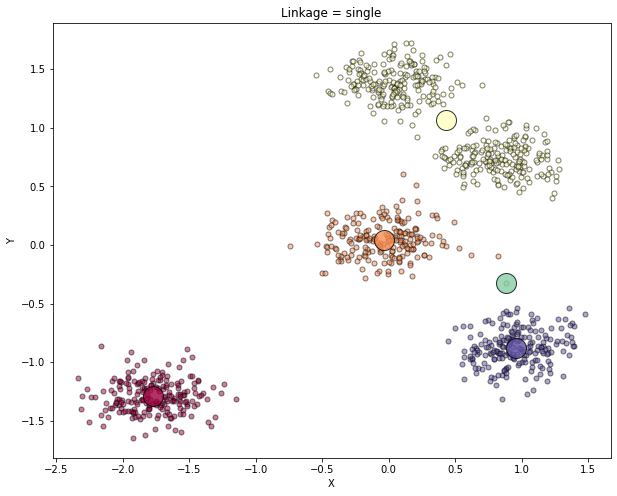

Silhouette Score:  0.5423196736714165
Davies-Bouldin Score:  0.49911973074283866
Cophenetic Correlation Coefficient:  0.8352409014156602

Linkage =  ward


<Figure size 432x288 with 0 Axes>

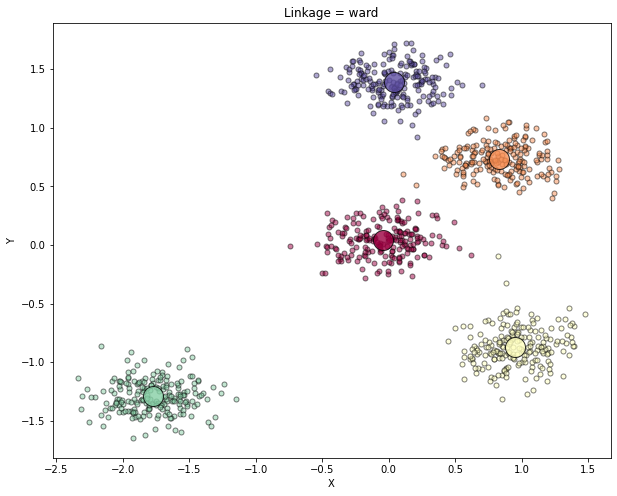

Silhouette Score:  0.7267712426325773
Davies-Bouldin Score:  0.3819110546065746
Cophenetic Correlation Coefficient:  0.9139326162467687

Linkage =  complete


<Figure size 432x288 with 0 Axes>

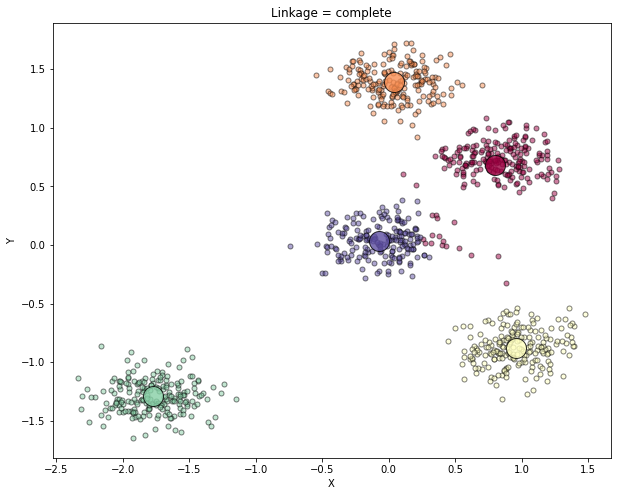

Silhouette Score:  0.7110045282745705
Davies-Bouldin Score:  0.3995673241702279
Cophenetic Correlation Coefficient:  0.8998126878321181


In [9]:
#First set up your parameters
n_agClusters=nTrue_Clusters #Set Number of Clusters

# Four different linkage options
links = {'ward','complete','single','average'}

for ilk in links:
    print("\nLinkage = ",ilk)
    #scikit-learn implementation
    clustering = AgglomerativeClustering(linkage=ilk, n_clusters=n_agClusters)
    clustering = clustering.fit(X)
    centers = getClusterCenters(X,clustering.labels_)
    
    #plot our results!
    fig = plt.figure()
    plot_clusters(clustering.labels_,centers,X,linkLabel=ilk)
    plt.show()
    rank_clusters(X,clustering.labels_)

    #sciPy implementation to check p-distance
    mergings = linkage(X, method=ilk, metric='euclidean')
    get_pdist(mergings,X)

***
***
# Make an elbow plot!

Just like with our k-Means example, we can make an elbow plot to judge our ideal cluster multiplicity.

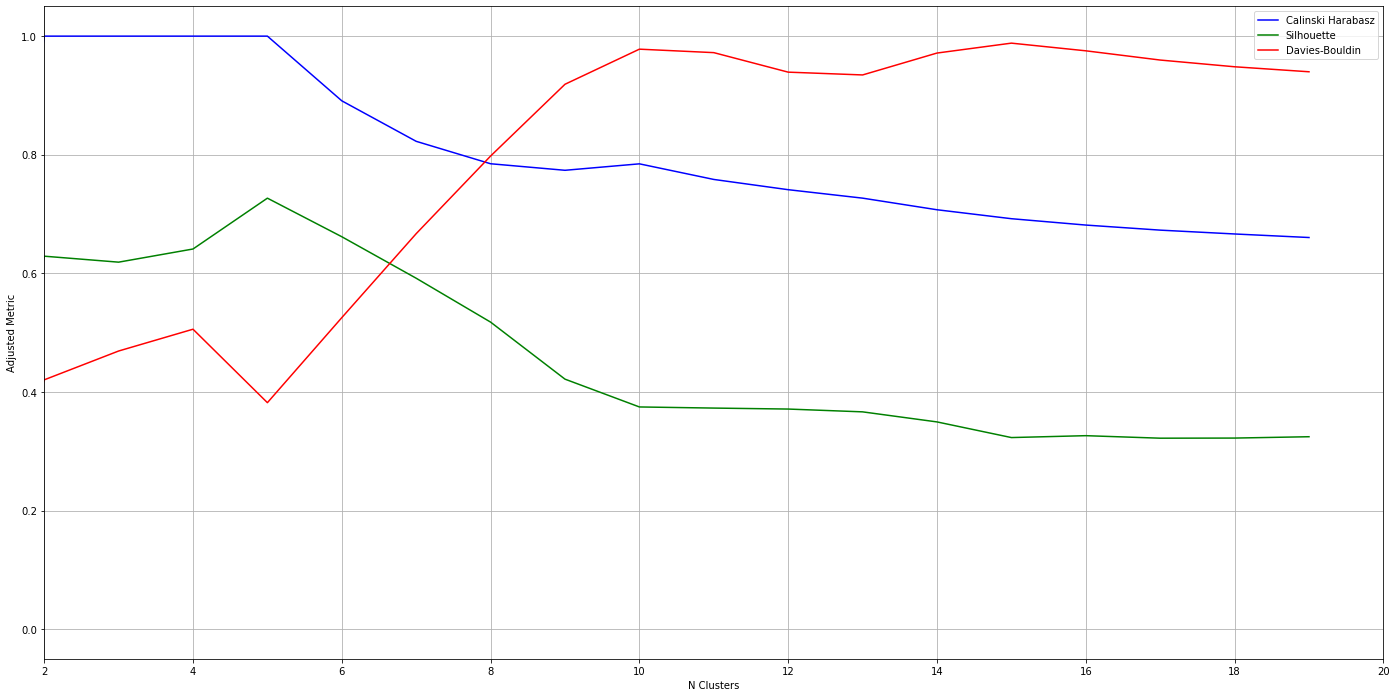

In [10]:
nClust_max = 20
cost = np.zeros((nClust_max,3)) #Custering cost

maxCalHar = 1
for iclust in range(2,nClust_max):

    #Use Ward linkage
    clustering = AgglomerativeClustering(linkage='ward', n_clusters=iclust)
    clustering = clustering.fit(X)
    centers = getClusterCenters(X,clustering.labels_)

    cost[iclust,0] = metrics.calinski_harabasz_score(X, clustering.labels_)
    maxCalHar = np.maximum(maxCalHar,cost[iclust,0])
    cost[iclust,0] /= maxCalHar
    cost[iclust,1] = metrics.silhouette_score(X,clustering.labels_) #larger is better!
    cost[iclust,2] = metrics.davies_bouldin_score(X,clustering.labels_) #lower is better!

    if True:
        clear_output(wait=True)
        plt.figure(101,figsize=(24,12))
        plt.plot(cost[:,0],'b-',label = 'Calinski Harabasz')
        plt.plot(cost[:,1],'g-',label = 'Silhouette')
        plt.plot(cost[:,2],'r-',label = 'Davies-Bouldin')
        plt.xlim(2,nClust_max)
        plt.xlabel("N Clusters")
        plt.ylabel("Adjusted Metric")
        plt.legend()
        plt.grid(True)
    
        plt.show()   

***
***
# Blind clustering

A difference relative to k-Means is that we can perform our clustering "blind" by not specifying the number of clusters to generate.  In this case, the algorithm will choose the largest distance scale over which the clusters persist and are not merged.  For this we need to specify a distance threshold.  We will see how this can be illustrated using the dendogram next.

<Figure size 432x288 with 0 Axes>

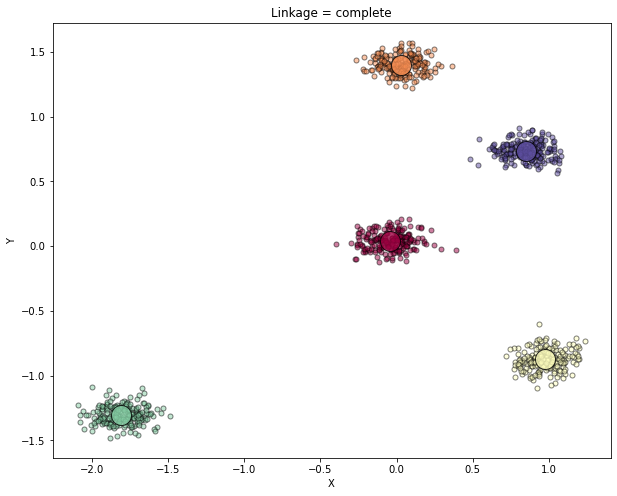

Silhouette Score:  0.8658256997156428
Davies-Bouldin Score:  0.18998967025585323


array([0.8658257 , 0.18998967])

In [88]:
#scikit-learn implementation
clustering = AgglomerativeClustering(linkage="complete", n_clusters=None, distance_threshold=1)
clustering = clustering.fit(X)
centers = getClusterCenters(X,clustering.labels_)

#plot our results!
fig = plt.figure()
plot_clusters(clustering.labels_,centers,X,linkLabel=ilk)
plt.show()
rank_clusters(X,clustering.labels_)

***
***
# N clusters vs Distance scale

Now let's investigate the number of clusters found vs the minimum distance required between clusters.

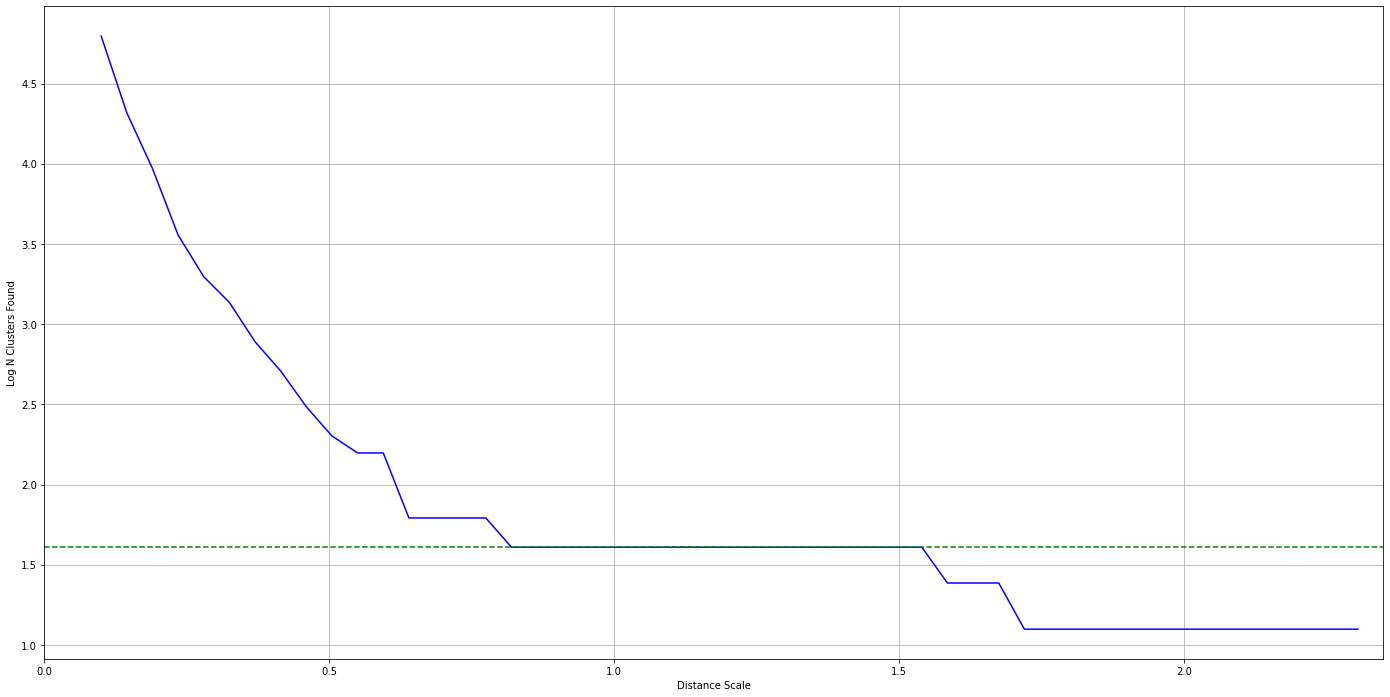

In [110]:
nSteps = 50
maxDist = 2.25
cost = np.zeros(nSteps) #Custering cost
dist = np.ones(nSteps)*maxDist

maxCalHar = 1
iclust = 0
for scl in np.arange(0.1,maxDist+0.1,maxDist/nSteps):
    
    #Use Ward linkage
    clustering = AgglomerativeClustering(linkage='complete', n_clusters=None,distance_threshold=scl)
    clustering = clustering.fit(X)
    centers = getClusterCenters(X,clustering.labels_)
    
    dist[iclust] = scl
    cost[iclust] = np.log(clustering.n_clusters_)
    iclust += 1
    
    if True:
        clear_output(wait=True)
        plt.figure(101,figsize=(24,12))
        plt.plot(dist,cost,'b-')

        plt.xlim(0,maxDist+0.1)
        plt.xlabel("Distance Scale")
        plt.ylabel("Log N Clusters Found")

        line = np.ones(nSteps)*np.log(nTrue_Clusters)
        
        plt.plot(line,"g--")
        plt.grid(True)
    
        plt.show()   

***
***
# Make a dendrogram!

And, finally, let's generate a dendrogram to study the number of cluster associations as function of distance scale.  This is just like above, but now we can visualize the linkage.

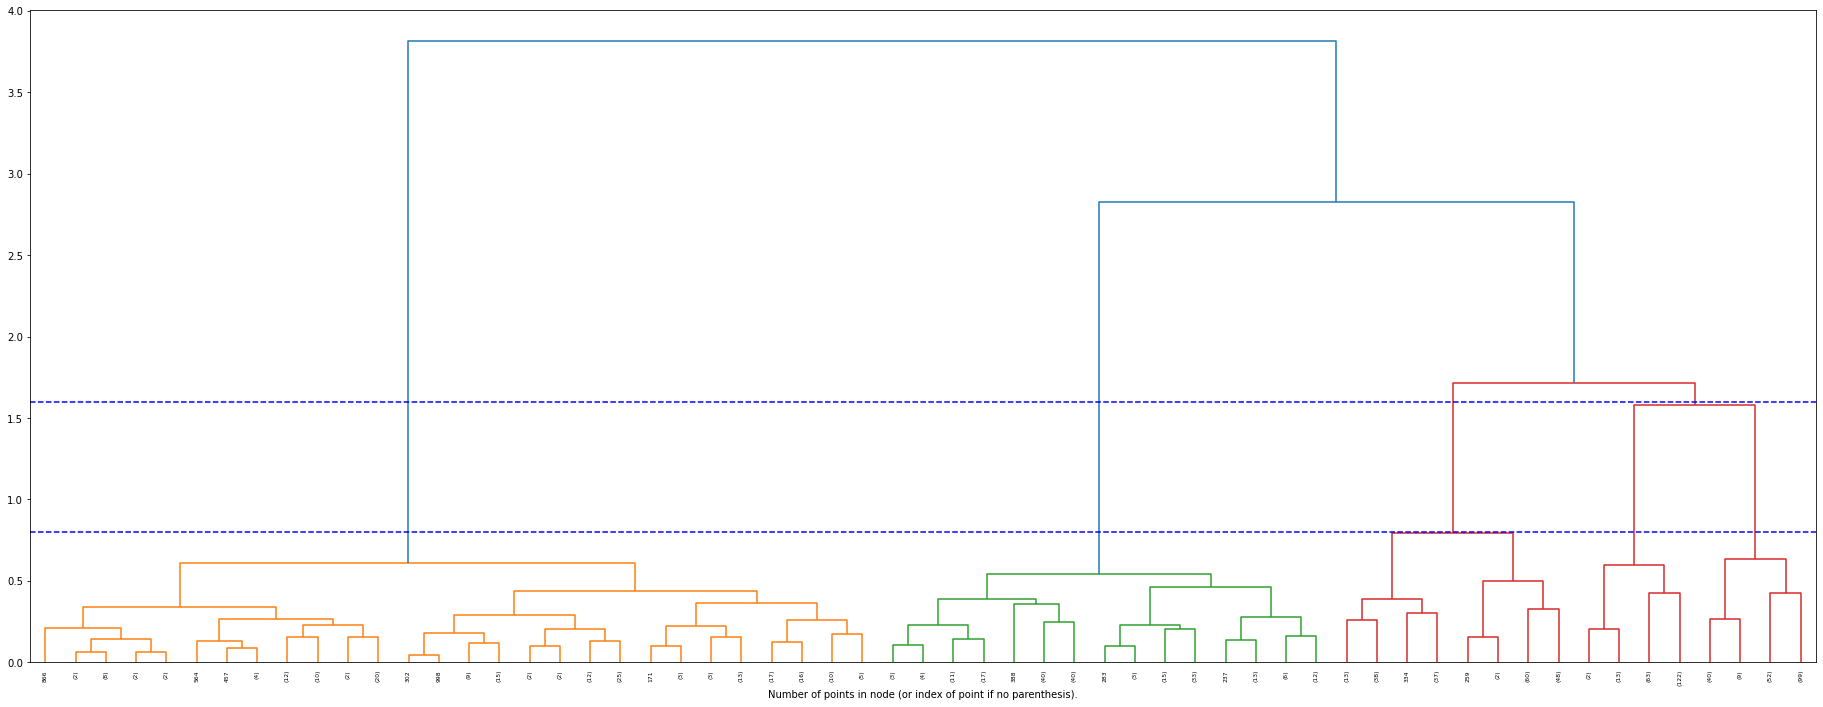

In [122]:

# generate the linkage and create a dendrogram
mergings = linkage(X, method='complete', metric='euclidean')

fig = plt.figure(figsize=(32,12))
# variable p sets the number of splits to show
dendrogram(mergings, truncate_mode='level', p=5)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
lo, hi = plt.xlim()
line1 = np.zeros((2,2))
line2 = np.zeros((2,2))
line1[:,[1]] = 0.8 #0.8,1.7
line1[1,0] = hi
line1[0,0] = lo
line2[:,[1]] = 1.6 #1.6, 2.8
line2[1,0] = hi
line2[0,0] = lo

plt.plot(line1[:,0],line1[:,1],"b--")
plt.plot(line2[:,0],line2[:,1],"b--")

plt.show()